In [1]:
import pandas as pd
import plotly.express as px

# Load data
taps = pd.read_csv("data/E/gho-tobacco-control-enforce-bans-on-tobacco-advertising-promotion-and-sponsorship.csv")

# Select latest year
if "IsLatestYear" in taps.columns and taps["IsLatestYear"].any():
    latest_year = taps.loc[taps["IsLatestYear"] == True, "Period"].max()
else:
    latest_year = taps["Period"].max()

taps_latest = taps[taps["Period"] == latest_year].copy()

# Level labels
level_labels = {
    2: "Level 2 — incomplete bans on TV/radio/press",
    3: "Level 3 — complete ban on TV/radio/press",
    4: "Level 4 — complete ban (TV/radio/press) + additional channels",
    5: "Level 5 — complete TAPS ban (all forms)",
}
category_order = [level_labels[k] for k in sorted(level_labels.keys())]

# Prepare columns
taps_latest = taps_latest[["Location", "ParentLocation", "SpatialDimValueCode", "Period", "Value"]].rename(
    columns={"SpatialDimValueCode": "ISO3", "Value": "TAPS_level"}
)
taps_latest["TAPS_label"] = taps_latest["TAPS_level"].map(level_labels)
taps_latest["TAPS_label"] = pd.Categorical(taps_latest["TAPS_label"], categories=category_order, ordered=True)

# Custom color map (blue shades)
color_discrete_map = {
    category_order[0]: "#f9e79f",  # light yellow
    category_order[1]: "#f7b731",  # orange
    category_order[2]: "#e67e22",  # dark orange
    category_order[3]: "#229954",  # green
}

# Choropleth map with all levels in legend
fig = px.choropleth(
    taps_latest,
    locations="ISO3",
    color="TAPS_label",
    hover_name="Location",
    hover_data={"ISO3": True, "ParentLocation": True, "TAPS_level": True, "TAPS_label": True},
    title=f"TAPS coverage index — latest available year ({latest_year})",
    category_orders={"TAPS_label": category_order},
    labels={"TAPS_label": "TAPS policy level"},
    color_discrete_map=color_discrete_map
)
fig.update_layout(legend_title_text="TAPS policy level")
fig.show()

> - **Title**: World map by policy level (WHO scale 2–5) for **T**obacco **A**dvertising, **P**romotion and **S**ponsorship.
> - Key messages:
>    - Just under a third of countries have achieved a complete ban on all forms of TAPS (level 5).
>    - The majority are at level 4 (complete bans on TV/radio/press + other channels, but not all), indicating that “grey areas” remain on some channels (e.g., digital, sponsorships, or POS).
>    - The map shows strong regional heterogeneity, with high-level clusters alongside mid/low-level areas.

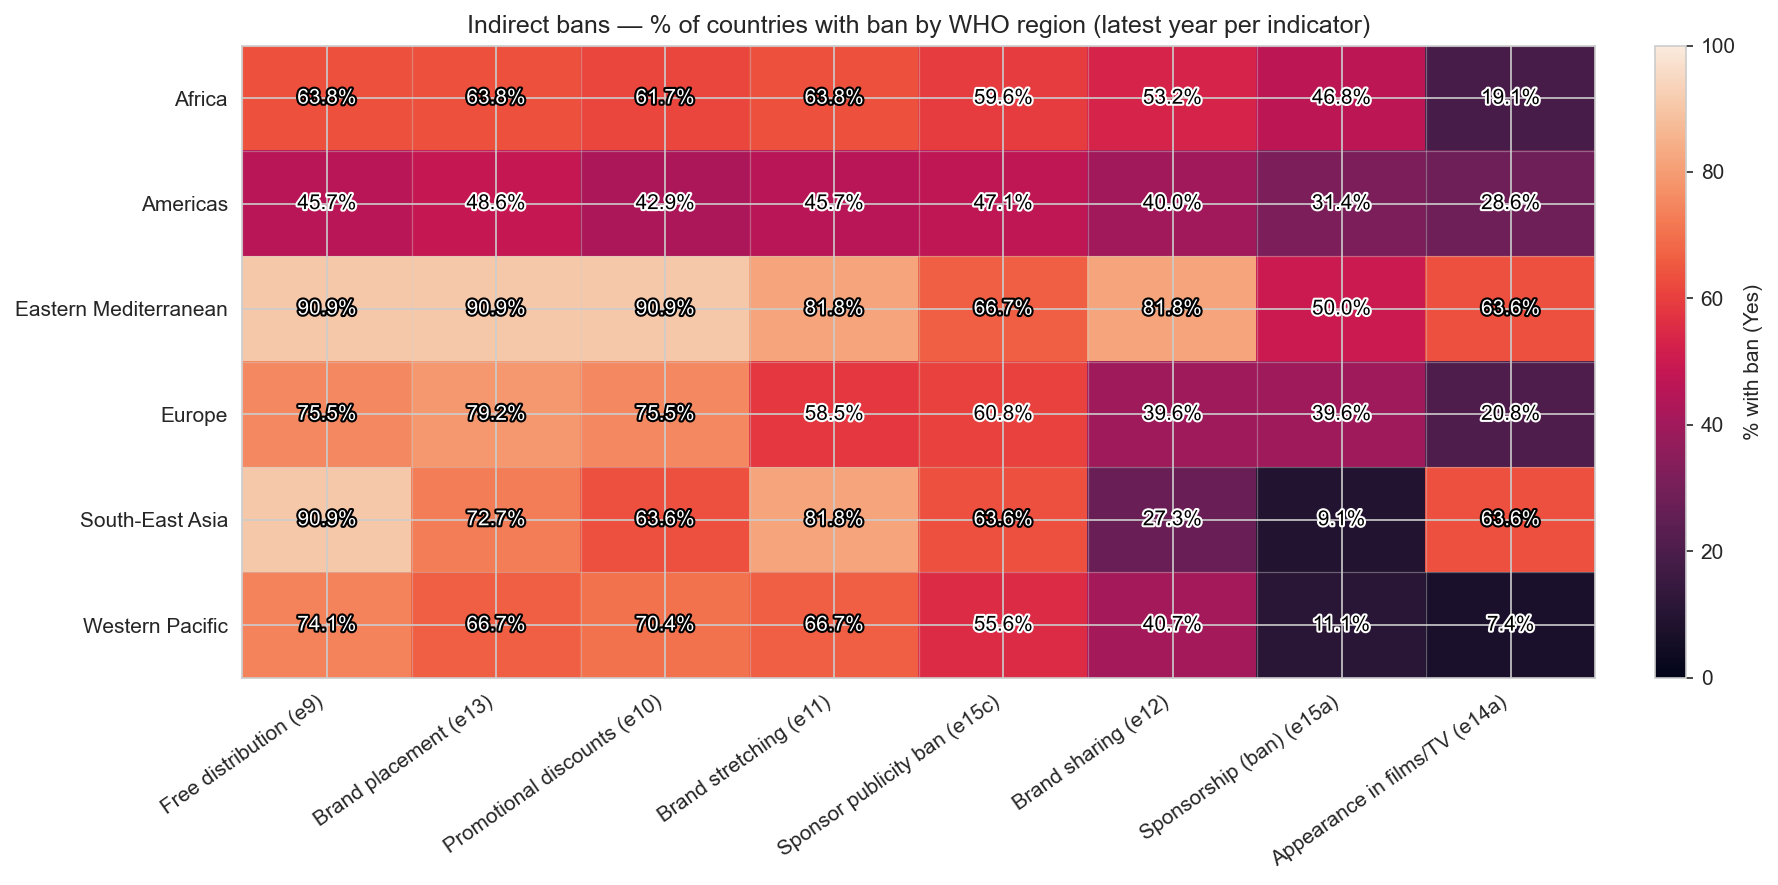

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# === Percorsi ai file (modifica se servono) ===
paths = {
    "Free distribution (e9)": "data/E/gho-tobacco-control-enforce-bans-e9-free-distrib.csv",
    "Promotional discounts (e10)": "data/E/gho-tobacco-control-enforce-bans-e10-promo-discounts.csv",
    "Brand stretching (e11)": "data/E/gho-tobacco-control-enforce-bans-e11-brand-stretching.csv",
    "Brand sharing (e12)": "data/E/gho-tobacco-control-enforce-bans-e12-brand-sharing.csv",
    "Brand placement (e13)": "data/E/gho-tobacco-control-enforce-bans-e13-brand-placement-.csv",
    "Appearance in films/TV (e14a)": "data/E/gho-tobacco-control-enforce-bans-e14a-prod-tv-films.csv",
    "Sponsorship (ban) (e15a)": "data/E/gho-tobacco-control-enforce-bans-e15a-sponsorship.csv",
    "Sponsor publicity ban (e15c)": "data/E/gho-tobacco-control-enforce-bans-e15c-sponsor-publicity.csv",
}

# Se True, ordina le colonne della heatmap per quota globale decrescente
ORDER_COLUMNS_BY_GLOBAL = True


# ---------- Helpers ----------
def load_std(path: str):
    """Legge CSV WHO e restituisce df + nomi colonne chiave (location/region/year/value)."""
    df = pd.read_csv(path)
    df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]
    loc = next(c for c in df.columns if c in ["location", "country", "spatialdim"])
    reg = next(c for c in df.columns if c in ["parentlocation", "region"])
    yr = next(c for c in df.columns if c in ["period", "year", "time_period"])
    val = "value" if "value" in df.columns else "factvaluenumeric"
    return df, loc, reg, yr, val


def clean_indicator(df, loc, reg, yr, val, pretty_name):
    """
    Mantiene solo Yes/No (esclude Not applicable), binarizza (Yes=1 No=0),
    seleziona l'ULTIMO anno disponibile per ciascun Paese,
    e restituisce location, region, year, indicator, bin.
    """
    use = df[[loc, reg, yr, val]].copy()
    use[yr] = pd.to_numeric(use[yr], errors="coerce")
    use = use.dropna(subset=[yr])

    # Normalizza a binario
    if use[val].dtype == object:
        use = use[use[val].isin(["Yes", "No"])].copy()
        use["bin"] = use[val].map({"Yes": 1, "No": 0})
    else:
        use["bin"] = (use[val].astype(float) >= 1).astype(int)

    # Un record per country-year (tieni l'ultimo), poi ultimo anno per Paese
    use = use.sort_values([loc, yr]).drop_duplicates(subset=[loc, yr], keep="last")
    use = use.sort_values([loc, yr]).drop_duplicates(subset=[loc], keep="last")

    use = use.rename(columns={loc: "location", reg: "region", yr: "year"})
    use["indicator"] = pretty_name
    return use[["location", "region", "year", "indicator", "bin"]]


# ---------- Caricamento & pulizia ----------
cleaned = []
for name, p in paths.items():
    df, loc, reg, yr, val = load_std(p)
    cleaned.append(clean_indicator(df, loc, reg, yr, val, name))

all_ind = pd.concat(cleaned, ignore_index=True)

# Ultimo anno per ciascun indicatore (lavoriamo "per colonna" all’ultimo anno disponibile)
latest_year = all_ind.groupby("indicator")["year"].max().rename("latest_year")
all_latest = all_ind.merge(latest_year, on="indicator")
all_latest = all_latest[all_latest["year"] == all_latest["latest_year"]].copy()

# --------- Quote per regione (Yes %) e denominatori ----------
shares = (all_latest.groupby(["region", "indicator"])["bin"]
          .agg(share_yes_pct=lambda s: round(100 * s.mean(), 1), denom="count")
          .reset_index())

heat = shares.pivot(index="region", columns="indicator", values="share_yes_pct").sort_index()
denoms = shares.pivot(index="region", columns="indicator", values="denom").sort_index()

# Quota globale per ordinare eventuale colonna
global_shares = (all_latest.groupby("indicator")["bin"].mean() * 100).round(1).sort_values(ascending=False)

if ORDER_COLUMNS_BY_GLOBAL:
    heat = heat[global_shares.index]  # riordina colonne
    denoms = denoms[global_shares.index]

# ---------- Plot: Heatmap con annotazioni ad alto contrasto ----------
Z = heat.values.astype(float)

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
# Colormap di default; scala fissa 0–100 per coerenza visiva
im = ax.imshow(Z, aspect="auto", vmin=0, vmax=100)

ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=35, ha="right")
ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)
ax.set_title("Indirect bans — % of countries with ban by WHO region (latest year per indicator)")

# Griglia leggera tra le celle
ax.set_xticks(np.arange(-.5, Z.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, Z.shape[0], 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.6, alpha=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotazioni con contrasto automatico + contorno
thr = np.nanmedian(Z)  # soglia dinamica per scegliere colore testo
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        val = Z[i, j]
        if np.isnan(val):
            continue
        txt_color = "white" if val >= thr else "black"
        outline = "black" if txt_color == "white" else "white"
        ax.text(j, i, f"{val:.1f}%", ha="center", va="center", fontsize=10,
                color=txt_color, path_effects=[pe.withStroke(linewidth=2, foreground=outline)])

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="% with ban (Yes)")
plt.tight_layout()
plt.show()

## ---------- Output tabellare (utile per la slide/note) ----------
#print("\nUltimo anno usato per ciascun indicatore:")
#print(latest_year.sort_index())
#
#print("\nDenominatori (Paesi con Yes/No, ultimo anno per indicatore):")
#print(denoms)
#
#print("\nQuote regionali (%):")
#print(heat)
#
#print("\nQuote globali (% con divieto) per indicatore (ordinamento decrescente):")
#print(global_shares)

> - **Title**: Indirect bans by type. Indicators e9–e15: free distribution, promotional discounts, brand placement/stretching/sharing, sponsorship/publicity, appearance in films/TV.
> - Key messages:
>     - Strong variation across items: bans on retail promotions are generally more widespread; brand sharing/extension and films/TV appearances tend to be weaker and uneven.
>     - Regional patterns: some regions show consistent coverage across multiple items, others remain fragmented, especially on media/entertainment and sponsorship.
>     - Displacement risk: weak items become landing zones for marketing activity (e.g., partnerships, placements, audiovisual content).
>     - Policy priorities: broaden definitions (cover digital, influencers, co-branding), add explicit bans on brand sharing/placement, ensure deterrent fines and enforcement tracking.

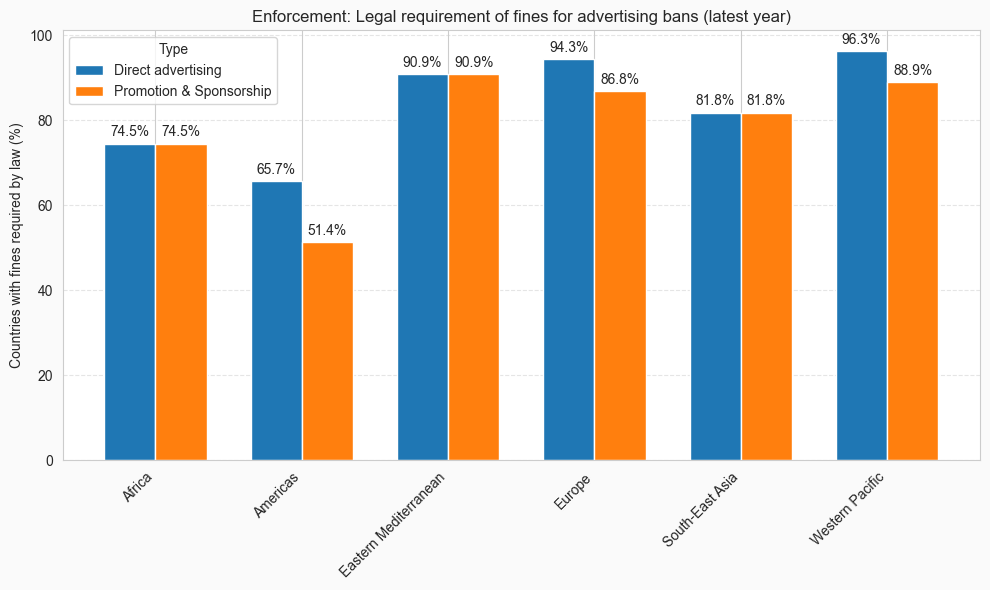

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load files
df_direct = pd.read_csv('data/E/gho-tobacco-control-enforce-bans-e21a-direct-ad-fines.csv')
df_indirect = pd.read_csv('data/E/gho-tobacco-control-enforce-bans-e21b-indirect-ad-fines.csv')

# Standardize column names
df_direct.columns = df_indirect.columns = [
    c.strip().lower().replace(" ", "_").replace("-", "_") for c in df_direct.columns
]

col_location = "location"
col_parent = "parentlocation"
col_period = "period"
col_value = "value"  # expects Yes/No/Not applicable


# Clean function: Yes → 1, all else (No, Not applicable, missing) → 0, keep latest year per country
def clean_yes_no_all(df):
    df = df[[col_location, col_parent, col_period, col_value]].copy()
    df["value_bin"] = (df[col_value] == "Yes").astype(int)
    df[col_period] = pd.to_numeric(df[col_period], errors="coerce")
    df = df.dropna(subset=[col_period])
    df = df.sort_values([col_location, col_period])
    idx = df.groupby(col_location)[col_period].idxmax()
    return df.loc[idx].copy()


df_direct_latest = clean_yes_no_all(df_direct)
df_indirect_latest = clean_yes_no_all(df_indirect)

df_direct_latest["type"] = "Direct advertising"
df_indirect_latest["type"] = "Promotion & Sponsorship"

df_combined = pd.concat([df_direct_latest, df_indirect_latest])

df_grouped = (
    df_combined.groupby([col_parent, "type"])
    .agg(
        countries=(col_location, "nunique"),
        with_fines=("value_bin", "sum"),
        share_fines_pct=("value_bin", lambda x: round(x.mean() * 100.0, 1))
    )
    .reset_index()
)

df_plot = df_grouped.pivot(index=col_parent, columns="type", values="share_fines_pct").fillna(0).sort_index()

fig, ax = plt.subplots(figsize=(10, 6), facecolor="#fafafa")
x = np.arange(len(df_plot.index))
width = 0.35
colors = ["#1f77b4", "#ff7f0e"]

bars1 = ax.bar(x - width / 2, df_plot["Direct advertising"], width, label='Direct advertising', color=colors[0])
bars2 = ax.bar(x + width / 2, df_plot["Promotion & Sponsorship"], width, label='Promotion & Sponsorship',
               color=colors[1])

ax.set_ylabel("Countries with fines required by law (%)")
ax.set_title("Enforcement: Legal requirement of fines for advertising bans (latest year)")
ax.set_xticks(x)
ax.set_xticklabels(df_plot.index, rotation=45, ha="right")
ax.legend(title="Type")
ax.grid(axis='y', linestyle='--', alpha=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.tight_layout()
plt.show()

> - **Title**: Legal requirement of fines for violations (latest year)
> - Key messages:
>    - The legal requirement of fines is widespread but uneven across regions.
>    - Direct advertising is often better covered than P&S, signalling a weak point in TAPS enforcement.
>    - Policy takeaway: align fine requirements across direct and P&S to prevent marketing displacement and ensure consistent bans.

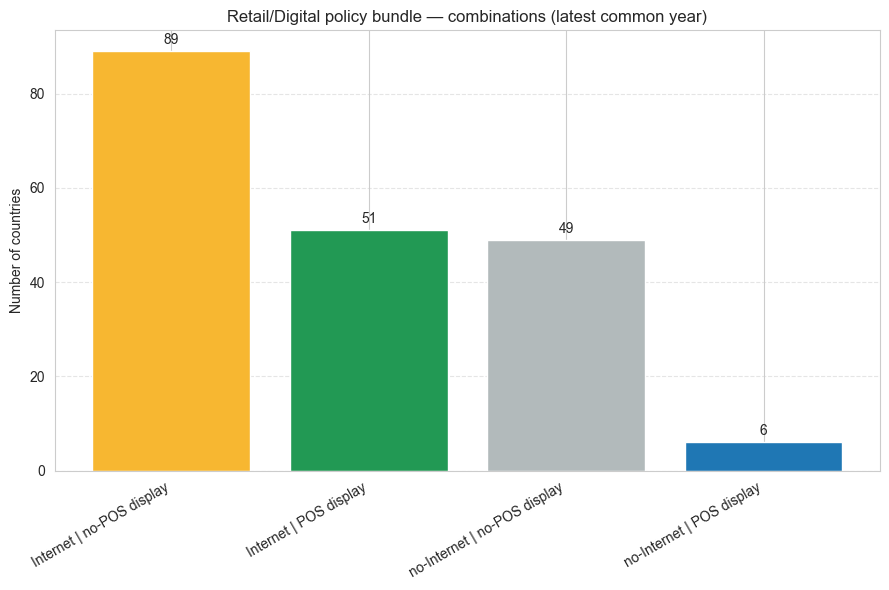

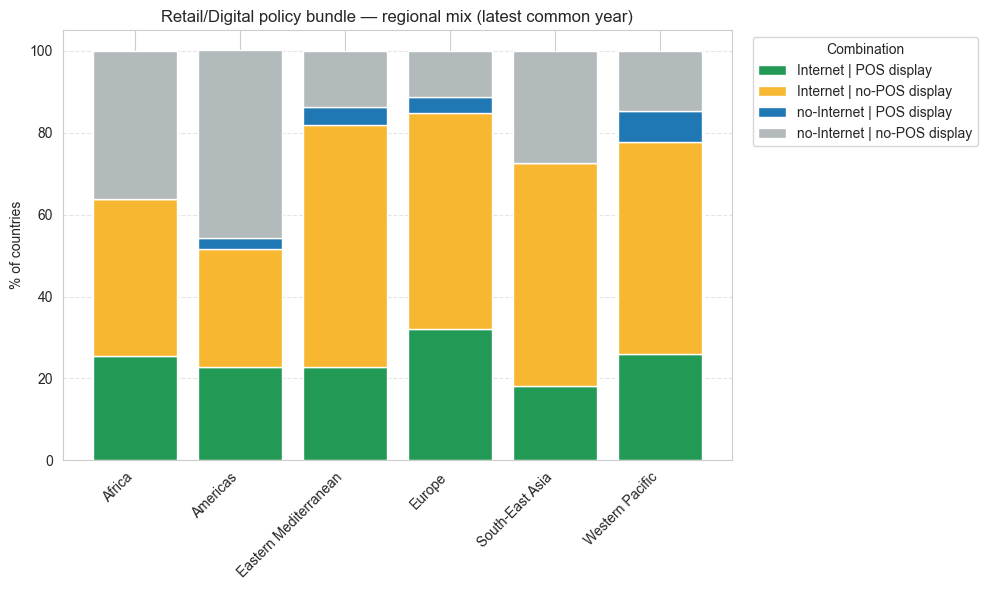

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File paths ===
p_internet_ad = 'data/E/gho-tobacco-control-enforce-bans-e7-internet.csv'
p_pos_display = 'data/E/ban-on-display-of-tobacco-products-at-points-of-sale.csv'


# --- Utility functions ---

def load_std(path):
    """Load CSV and standardize column names."""
    df = pd.read_csv(path)
    df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]
    return df


def find_cols(df):
    """Detect key columns for location, region, year, and value."""
    loc = next(c for c in df.columns if c in ["location", "country", "spatialdim"])
    reg = next(c for c in df.columns if c in ["parentlocation", "region"])
    yr = next(c for c in df.columns if c in ["period", "year", "time_period"])
    val = "value" if "value" in df.columns else "factvaluenumeric"
    return loc, reg, yr, val


def prep_indicator(df, loc_col, reg_col, yr_col, val_col, name):
    """Prepare indicator: Yes→1, all else→0, keep latest year per country."""
    out = df[[loc_col, reg_col, yr_col, val_col]].copy()
    out[yr_col] = pd.to_numeric(out[yr_col], errors="coerce")
    out = out.dropna(subset=[yr_col])
    # Map Yes→1, all else (No, Not applicable, missing)→0
    out["bin"] = (out[val_col] == "Yes").astype(int)
    # Keep only the latest year per country
    out = out.sort_values([loc_col, yr_col]).drop_duplicates(subset=[loc_col], keep="last")
    out = out.rename(columns={loc_col: "location", reg_col: "region", yr_col: "year"})
    out[name] = out["bin"].astype(int)
    return out[["location", "region", "year", name]]


# --- Load and process data ---

df_e7 = load_std(p_internet_ad)
df_pos = load_std(p_pos_display)

loc_e7, reg_e7, yr_e7, val_e7 = find_cols(df_e7)
loc_pos, reg_pos, yr_pos, val_pos = find_cols(df_pos)

e7 = prep_indicator(df_e7, loc_e7, reg_e7, yr_e7, val_e7, "internet_ad_ban")
pos = prep_indicator(df_pos, loc_pos, reg_pos, yr_pos, val_pos, "pos_display_ban")

# --- Find latest common year ---
latest_common_year = int(min(e7["year"].max(), pos["year"].max()))
e7_y = e7[e7["year"] == latest_common_year]
pos_y = pos[pos["year"] == latest_common_year]

# --- Merge: only countries with both values ---
merged = pd.merge(e7_y, pos_y, on=["location", "region", "year"], how="inner")


# --- Combination label ---
def combo_label(row):
    return ("Internet" if row["internet_ad_ban"] == 1 else "no-Internet") + " | " + \
        ("POS display" if row["pos_display_ban"] == 1 else "no-POS display")


merged["combo"] = merged.apply(combo_label, axis=1)

# --- Overall counts ---
counts_overall = (merged.groupby("combo")["location"]
                  .nunique()
                  .sort_values(ascending=False)
                  .rename("countries")
                  .reset_index())

# --- Shares by region ---
counts_by_region = (merged.groupby(["region", "combo"])["location"].nunique()
                    .rename("countries").reset_index())
region_tot = merged.groupby("region")["location"].nunique().rename("total").reset_index()
shares_by_region = counts_by_region.merge(region_tot, on="region")
shares_by_region["share_pct"] = (100 * shares_by_region["countries"] / shares_by_region["total"]).round(1)

# --- Color palette for combinations ---
combo_colors = {
    "Internet | POS display": "#229954",  # green
    "Internet | no-POS display": "#f7b731",  # orange
    "no-Internet | POS display": "#1f77b4",  # blue
    "no-Internet | no-POS display": "#b2babb"  # grey
}
# Ensure all combos are present
for combo in merged["combo"].unique():
    if combo not in combo_colors:
        combo_colors[combo] = "#b2babb"

# === Plot 1: UpSet-like bar (overall) ===
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.bar(counts_overall["combo"], counts_overall["countries"],
              color=[combo_colors[c] for c in counts_overall["combo"]])
ax.set_title("Retail/Digital policy bundle — combinations (latest common year)")
ax.set_ylabel("Number of countries")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_xticks(np.arange(len(counts_overall["combo"])))
ax.set_xticklabels(counts_overall["combo"], rotation=30, ha="right")
for i, y in enumerate(counts_overall["countries"]):
    ax.annotate(str(int(y)), (i, y), xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# === Plot 2: Stacked by region (share %) ===
pivot_shares = shares_by_region.pivot(index="region", columns="combo", values="share_pct").fillna(0).sort_index()
fig2, ax2 = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(pivot_shares))
x = np.arange(len(pivot_shares.index))
for combo in pivot_shares.columns:
    ax2.bar(x, pivot_shares[combo].values, bottom=bottom, label=combo, color=combo_colors.get(combo, "#b2babb"))
    bottom += pivot_shares[combo].values
ax2.set_xticks(x)
ax2.set_xticklabels(pivot_shares.index, rotation=45, ha="right")
ax2.set_ylim(0, 105)
ax2.set_ylabel("% of countries")
ax2.set_title("Retail/Digital policy bundle — regional mix (latest common year)")
ax2.legend(title="Combination", bbox_to_anchor=(1.02, 1), loc="upper left")
ax2.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

>- **Title**: Policy bundle: bans on Internet advertising and POS display.
>- Key messages:
>    - The most common bundle is Internet = yes / POS = no → a storefront loophole remains.
>    - Internet = yes / POS = yes is present but not dominant; comparatively stronger in some mature regions (e.g., Europe, Western Pacific).
>    - POS = yes without Internet is rare everywhere.
>    - Several regions still show Internet = no / POS = no, indicating incomplete uptake.
>    - Effectiveness improves when both measures are combined; prioritize closing POS, updating Internet bans (social media, influencers, cross-border ads), and aligning fines/inspections.